# MNIST Images Classification with Convolutional Neural Networks & Keras

## Introduction
In this report, we will design a simple Convolutional Neural Network model using keras with tensorflow backend for the well known MNIST digit recognition task. 


**Mounting Google Drive into Google Colab Workspace**  
The data are all saved in my Google Drive 

In [1]:
import sys
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.append('/content/gdrive/My Drive/Colab Notebooks')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Imports**

In [2]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
import gzip
import os.path
import matplotlib.image as mpimg
rdm_seed = 29
np.random.seed(rdm_seed)

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.callbacks import ReduceLROnPlateau
from keras.models import load_model

base_path = 'gdrive/My Drive/Colab Notebooks/MNIST_CNN_Keras'

Using TensorFlow backend.


### Loading the data
Few details about the file format (obtained from [Original Host Website](http://yann.lecun.com/exdb/mnist/)) 
All the integers in the files are stored in the MSB first (high endian) format. There are 4 files containing {train, test} x {data, labels}. 
* train-images-idx3-ubyte.gz - contains training data (images)
* train-labels-idx1-ubyte.gz - contains the training labels
* t10k-images-idx3-ubyte.gz - contains the testing data (images)
* t10k-labels-idx1-ubyte.tz - contains the testing labels

The training set contains 60000 examples, and the test set 10000 examples. The data are all stored in uint8 format and zipped in .gz files. We use gzip tool to load the data and convert the data into np arrays.

The data (image) files are stored as follows
* The first 16 (8-bit) entries contain information about the image data
  * data[6], data[7] store the number of images in the file
  * data[11] contains the number of rows used to store each image
  * data[15] contains the number of columns used to store each image
The label files are stored as follows
* The first 8 (8-bit) entries contain information about the label data
  * data[6], data[7] contains the number of labels in the file

In [0]:
f = gzip.open(base_path+'/Data/train-labels-idx1-ubyte.gz','r')
data = np.frombuffer(f.read(8), dtype=np.uint8).astype(np.int64)
num_labels = data[6]*2**8+data[7]
y_train = np.frombuffer(f.read(num_labels), dtype=np.uint8).astype(np.int64)
y_train = pd.DataFrame(y_train, columns = ['Labels'])

In [0]:
f = gzip.open(base_path+'/Data/train-images-idx3-ubyte.gz','r')
data = np.frombuffer(f.read(16), dtype=np.uint8).astype(np.int64)
train_num_images = data[6]*2**8+data[7]
train_image_size = [data[11], data[15]]
buf = f.read(train_image_size[0] * train_image_size[1] * train_num_images)
X_train = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
X_train = X_train.reshape(train_num_images, train_image_size[0]*train_image_size[1])
X_train = pd.DataFrame(X_train)

In [0]:
f = gzip.open(base_path+'/Data/t10k-labels-idx1-ubyte.gz','r')
data = np.frombuffer(f.read(8), dtype=np.uint8).astype(np.int64)
num_labels = data[6]*2**8+data[7]
y_test = np.frombuffer(f.read(num_labels), dtype=np.uint8).astype(np.int64)
y_test = pd.DataFrame(y_test, columns = ['Labels'])

In [0]:
f = gzip.open(base_path+'/Data/t10k-images-idx3-ubyte.gz','r')
data = np.frombuffer(f.read(16), dtype=np.uint8).astype(np.int64)
test_num_images = data[6]*2**8+data[7]
test_image_size = [data[11], data[15]]
buf = f.read(test_image_size[0] * test_image_size[1] * test_num_images)
X_test = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
X_test = X_test.reshape(test_num_images, test_image_size[0]*test_image_size[1])
X_test = pd.DataFrame(X_test)

## Exploratory Data Analysis

**Shape of training and testing data sets**

In [7]:
print('Shape of train data set: ', X_train.shape)
print('Shape of train label set: ', y_train.shape)
print('Shape of test data set: ', X_test.shape)
print('Shape of test label set: ', y_test.shape)

Shape of train data set:  (60000, 784)
Shape of train label set:  (60000, 1)
Shape of test data set:  (10000, 784)
Shape of test label set:  (10000, 1)


### Missing Values

In [8]:
print('Does any of the training data set values contain Null data?', X_train.isnull().any().any())
print('Does any of the test data set values contain Null data?', X_test.isnull().any().any())

Does any of the training data set values contain Null data? False
Does any of the test data set values contain Null data? False


None of the images seem to be corrupt and the dataset is clean with no NULL values. 

### Distribution of Labels

In [9]:
y_train['Labels'].value_counts()

1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: Labels, dtype: int64

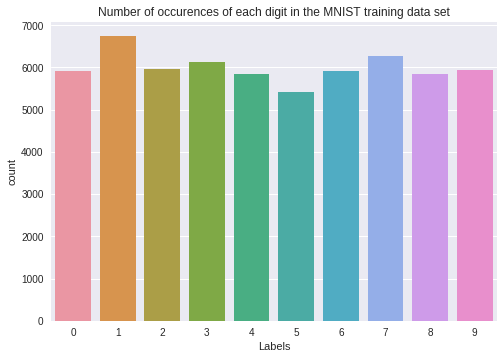

In [10]:
sns.countplot(y_train['Labels'])
plt.title('Number of occurences of each digit in the MNIST training data set')
plt.show()

**Observations**
* The disribution of each of the digits are fairly 
* Minimum occurence digit is 5 with count value of 5421 
* Maximum occurence digit is 1 with count value of 6742 

### Image Plots
Below are plots of the first 15 MSIT digit images and its corresponding labels as the title. 

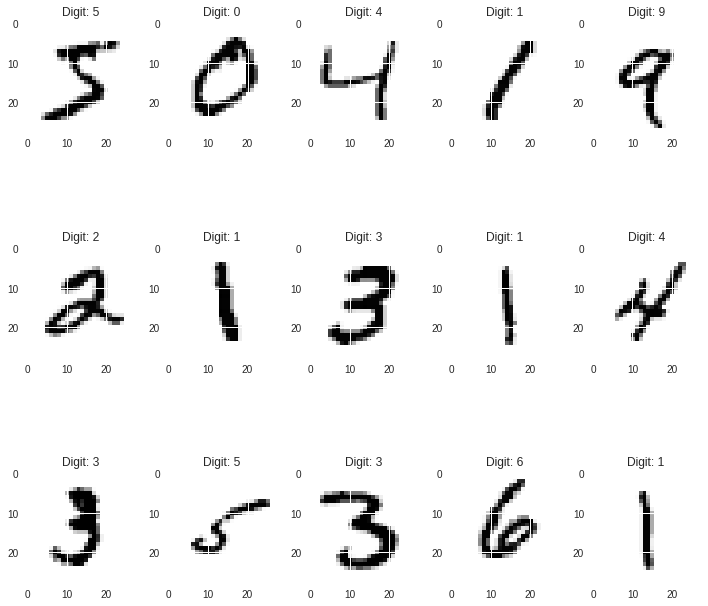

In [11]:
fig = plt.figure(figsize=(10, 10))
for i in range(15):
  axes = fig.add_subplot(3, 5, i+1)
  image = np.asarray(X_train.loc[i,:].values.reshape(28, 28)).squeeze()
  plt.imshow(image)
  plt.title('Digit: {0}'.format(y_train.loc[i, 'Labels']))

plt.tight_layout()
plt.show()

### Feature Engineering

**Normalization**  
The pixel values lie between 0 and 255. We normalize it to the range between 0 and 1 for better CNN convergence

In [0]:
X_train = X_train/255.0
X_test = X_test/255.0

**One-Hot Encoding**  
To use keras, we have to first one-hot encode the y-labels. This essentially converts each of the labels (which ranges from 0 to 9) into a 10-length binary vector with one and only one of the position = 1 (which corresponds to the label value)

**Reshaping**  
All the images stored in pandas DataFrame is in the form 1D Vectors of length 784 (= 28x28). We reshape them all to 28x28x1 3D matrix. Keras requires an extra dimension in the end which correspond to channels. MNIST images are gray scaled so it use only one channel. For RGB images, there is 3 channels, we would have reshaped 784px vectors to 28x28x3 3D matrices

In [0]:
y_train = np_utils.to_categorical(y_train, num_classes = 10)
y_test = np_utils.to_categorical(y_test, num_classes = 10)

In [0]:
X_train = X_train.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)

In [15]:
print('Shape of train data set: ', X_train.shape)
print('Shape of train label set: ', y_train.shape)
print('Shape of test data set: ', X_test.shape)
print('Shape of test label set: ', y_test.shape)

Shape of train data set:  (60000, 28, 28, 1)
Shape of train label set:  (60000, 10)
Shape of test data set:  (10000, 28, 28, 1)
Shape of test label set:  (10000, 10)


## Modeling

### Train-Validation Split
Let us split the dataset with 90% as the training data set and the remaining 10% as our validation set. We use train_test_split since all the labels are more or less evenly occuring. Else we could have used stratified split

In [0]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=rdm_seed)

### CNN Model
Below block diagram provides a summary of the Model that we are building. It consists of
1.   First Convolutional Layer: Uses 32 (3x3) kernel Filters
  * Input = Image as a num_images x 28x28x1 matrix (num_rows = 28, num_columns = 28 and num_channels = 1)
  * Number of filters = 32
  * Kernel = 3x3
  * maxPooling2D with stride of 2 to reduce the dimensionality of num_rows and num_columns by 2
  * Dropout of 20% to randomly null out neurons to avoid over-fit
  * Activation Function = ReLu(x) = max(0, x)
  * Output = 14x14x32  
  
2.   Second Convolutional Layer
  * Input = 14x14x32
  * Number of filters = 128
  * Kernel = 3x3
  * maxPooling2D wtih stride = 2
  * Activation Function = ReLu(x)
  * Output = 7x7x128
  
3. Flatten
  * Input = 7x7x128
  * Output = 1x6272

4. Dense Fully Connected Layer
  * Input: 1x6272
  * Dropout of 20% to randomly null out neurons to avoid over-fit
  * Activation Function = ReLu(x)
  * Output: 1x1000
  
5. Dense Fully Connected Layer
  * Input: 1x1000
  * Dropout of 50% to randomly null out neurons to avoid over-fit
  * Activation Function = ReLu(x)
  * Output: 1x500
 
6. Output Layer
  * Input: 1x500
  * Activation Function = Softmax
  * Output: 1x10

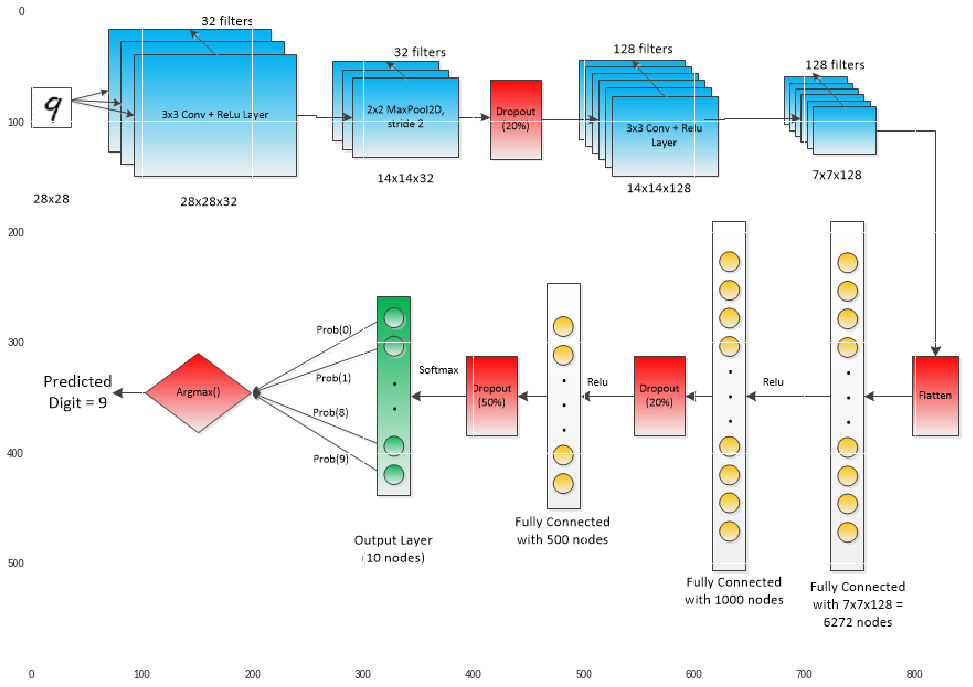

In [17]:
img=mpimg.imread(base_path+'/Images/cnn_block_diagram.png')
plt.figure(figsize=(18, 12))
imgplot = plt.imshow(img)
plt.show()

In [18]:
model = Sequential()
model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.2))
model.add(Conv2D(filters = 128, kernel_size = (3,3), padding = 'Same', activation ='relu'))
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
#model.add(Conv2D(filters = 512, kernel_size = (3,3), padding = 'Same', activation ='relu'))
#model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1000, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(500, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

lr_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)
sgd_optimizer = SGD(lr = 0.01)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 128)       36992     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              6273000   
__________

In [0]:
generate_model = 0
epochs = 10
batch_size = 128
if generate_model:
  model.fit(X_train, y_train,
            batch_size=batch_size,
            epochs=epochs,
            verbose=1,
            validation_data=(X_val, y_val),
            callbacks=[lr_reduction])

  # Saving the model
  save_dir = base_path+"/Application/models/"
  model_name = 'keras_mnist.h5'
  model_path = os.path.join(save_dir, model_name)
  model.save(model_path)
  print('Saved trained model at {0} '.format(model_path))

### Model Evaluation

In [21]:
model_path = base_path+"/Application/models/keras_mnist.h5"
mnist_model = load_model(model_path)

Instructions for updating:
Use tf.cast instead.


In [0]:
y_pred = mnist_model.predict(X_val)

In [23]:
y_val_pred = np.argmax(y_pred, axis=1)
y_val_true = np.argmax(y_val, axis=1)
confusion_matrix(y_val_true, y_val_pred)

array([[640,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0, 650,   2,   0,   0,   0,   1,   0,   0,   0],
       [  0,   0, 592,   0,   0,   0,   0,   4,   0,   0],
       [  0,   0,   1, 629,   0,   3,   0,   0,   0,   0],
       [  0,   2,   0,   0, 570,   0,   0,   0,   2,   1],
       [  0,   0,   0,   1,   0, 555,   1,   0,   1,   0],
       [  1,   1,   0,   0,   0,   0, 583,   0,   1,   0],
       [  1,   1,   1,   0,   1,   0,   0, 572,   0,   1],
       [  1,   0,   1,   1,   0,   0,   0,   0, 595,   1],
       [  0,   0,   0,   0,   2,   1,   0,   1,   0, 579]])

In [0]:
y_pred = mnist_model.predict(X_test)

In [25]:
y_test_pred = np.argmax(y_pred, axis=1)
y_test_true = np.argmax(y_test, axis=1)
confusion_matrix(y_test_true, y_test_pred)

array([[ 978,    0,    0,    0,    0,    0,    0,    1,    1,    0],
       [   0, 1134,    0,    0,    0,    0,    0,    0,    1,    0],
       [   1,    0, 1026,    0,    0,    0,    0,    4,    1,    0],
       [   0,    0,    0, 1005,    0,    3,    0,    0,    2,    0],
       [   0,    1,    0,    0,  976,    0,    1,    0,    1,    3],
       [   2,    0,    0,    4,    0,  884,    1,    0,    1,    0],
       [   3,    2,    0,    0,    1,    0,  951,    0,    1,    0],
       [   0,    2,    2,    0,    0,    0,    0, 1020,    1,    3],
       [   3,    0,    1,    0,    0,    0,    0,    0,  969,    1],
       [   0,    1,    0,    0,    7,    3,    0,    4,    2,  992]])

We can see that the most common mis-classified digits are from 9 to 4 and 5 to 3

In [26]:
val_accuracy = (y_val_pred==y_val_true).sum()/len(y_val_pred)
test_accuracy = (y_test_pred==y_test_true).sum()/len(y_test_pred)
print('Validation Accuracy = {0:.3f}'.format(val_accuracy))
print('Test Accuracy = {0:.3f}'.format(test_accuracy))

Validation Accuracy = 0.994
Test Accuracy = 0.994


The model is fairly accurate with an accuracy of 99.4% on test and validation sets. Now let us look at few classifications performed by the model. The test indices below have been handpicked by looking at few error instances. 

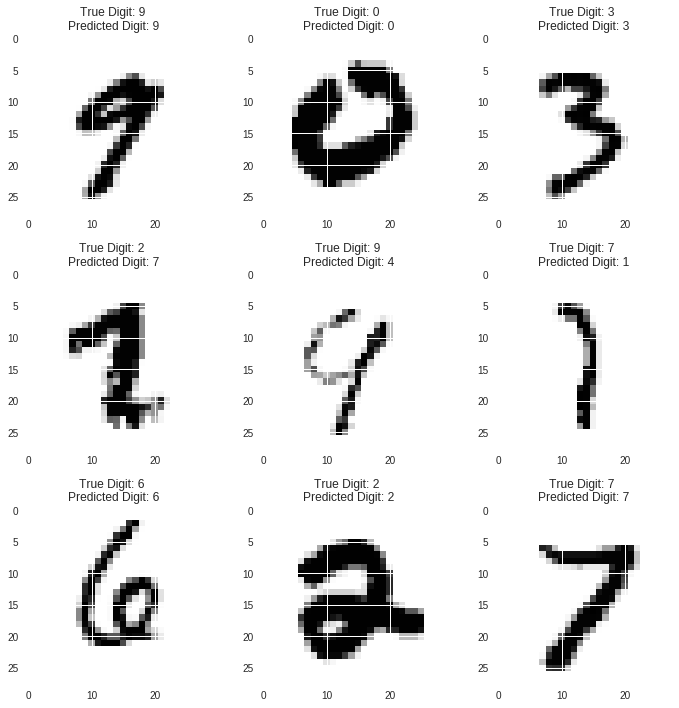

In [28]:
idx = [20,  25,  30,  659,  882, 1260, 123, 222, 34]

fig = plt.figure(figsize=(10, 10))
for i, idx in enumerate(idx):
  axes = fig.add_subplot(3, 3, i+1)
  image = np.asarray(X_test[idx,:].reshape(28, 28)).squeeze()
  plt.imshow(image)
  plt.title('True Digit: {0} \nPredicted Digit: {1}'.format(y_test_true[idx], y_test_pred[idx]))

plt.tight_layout()
plt.show()

### Error Images
Let us take a look at the top mis-classified digits


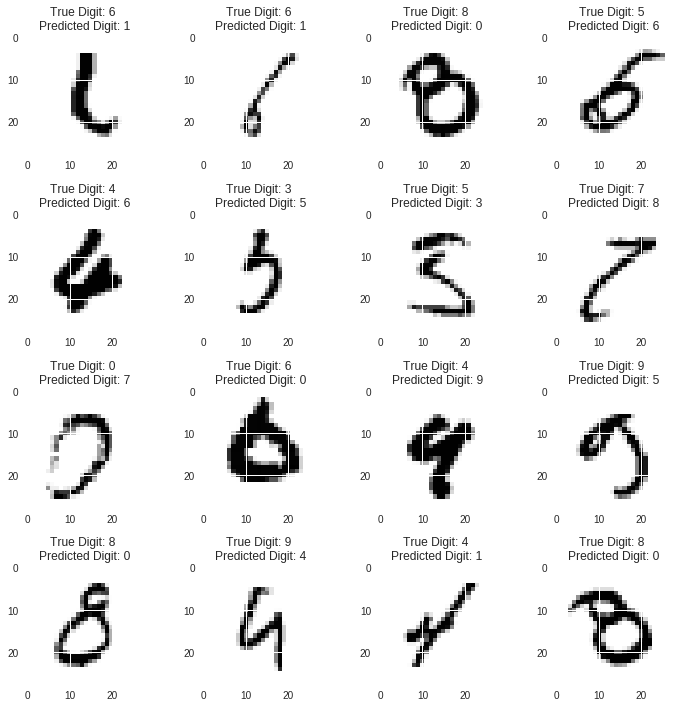

In [29]:
error_idx = (y_test_pred!=y_test_true)
X_test_err = X_test[error_idx,:]
y_test_pred_err = y_test_pred[error_idx]
y_test_true_err = y_test_true[error_idx]
y_pred_err = y_pred[error_idx]


y_pred_err_prob = np.max(y_pred_err, axis=1) # Probability of the incorrectly predicted number
true_prob_err = y_pred_err[range(y_pred_err.shape[0]), y_test_true_err] # Probability of true values in the error set
prob_diff = y_pred_err_prob - true_prob_err
sorted_err_idx = np.argsort(-prob_diff)

fig = plt.figure(figsize=(10, 10))
for i in range(16):
  axes = fig.add_subplot(4, 4, i+1)
  image = np.asarray(X_test_err[sorted_err_idx[i],:].reshape(28, 28)).squeeze()
  plt.imshow(image)
  plt.title('True Digit: {0} \nPredicted Digit: {1}'.format(y_test_true_err[sorted_err_idx[i]], y_test_pred_err[sorted_err_idx[i]]))

plt.tight_layout()
plt.show()

From the above mis-classification, we can see that the digits that are incorrectly classified are not clearly written. Few of them are slanted, we of them are broken. 

## Conclusions
We built a Convolutional Neural Network model to predict MNIST handwritten digits. The model uses 2 convolutional layers with ReLu activation function (for non-linearization) and max-pooling (for dimensionality reduction by extracting dominant features). The data is then fed to a 2 dense and fully connected neural network layers which again uses Relu activation function. Finally, we use a softmax activation function at the output layer to make decisions on the 10 possible digit outcomes. Below is a short summary of the conclusions made
* The model predicts the digit correctly with an accuracy of 99.4% (the occurence of digits are evenly distributed. Hence accuracy is a good metric for performance)
* Most mis-classified digits are from 9 to 4




### Ideas to improve model predictions
* Use Data Augmentation to include more training data. Data augmentation can be used to modify the existing images and use it for training. For example
  * Scale the image (both increase and decrease)
  * Shift the image off the center
  * Rotate the image